In [2]:
from scipy import optimize
import cvxopt
import matplotlib.pyplot as plt
import numpy as np
import sympy
sympy.init_printing()

# 优化问题分类

研究的问题限定在实值范围，且不处理离散数据。

最常见的是最小化问题，如 $\min_{x}f(x)$，在 m 个等式 $g(x)=0$ 及其 p 个不等式 $h(x) \le 0$ 约束条件下。

依据$f(x),g(x),h(x)$ 优化问题可以分为：
- 单变量(一维) 如果 x 是个标量
- 多变量(多维) 如果 x 是个矢量

如果目标函数和约束是线性的，那么就是线性优化问题或线性方程问题。如果是非线性的，那么就是非线性优化问题，或非线性方程问题。

非线性问题较难解，但对于凸优化问题（有全局最小值或最大值）还是有高效的求解方法。凸问题可以定义为 在[a,b]区间内的值，都在(a,f(a)),(b,f(b))以下。如下图，左侧是凸优化问题，右侧则不是：
![image](https://wx3.sinaimg.cn/large/69d4185bly1fy9znwlm5tj20iw064mxl.jpg)

约束返程的连续和平滑性也会影响到约束问题的求解。

使用导数来求解直接，在导数为零的点可能是最大值，也可能是最小值，甚至有可能是鞍点。如下图：
![image](https://wx2.sinaimg.cn/large/69d4185bly1fy9zrin6eij20it04naae.jpg)

通常会使用二阶导数来验证是否是最大值或者最小值。

# 单变量优化

可以使用 `golden` 来求解，此方法安全，但是速度相对较慢。 

如下，在体积为 1 的情况下，求最小化圆柱面积，高为 h，底面半径为 r。可视化为：
![image](https://ws2.sinaimg.cn/large/69d4185bly1fya0my4vcmj20g707cdg5.jpg)

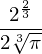

In [3]:
r, h = sympy.symbols("r, h")
Area = 2 * sympy.pi * r**2 + 2 * sympy.pi * r * h
Volume = sympy.pi * r**2 * h
h_r = sympy.solve(Volume - 1)[0]
Area_r = Area.subs(h_r)
rsol = sympy.solve(Area_r.diff(r))[0]
rsol

In [4]:
_.evalf()

In [5]:
Area_r.diff(r, 2).subs(r, rsol)

In [9]:
Area_r.subs(r, rsol)

In [7]:
_.evalf()

使用 `brent` 方法

In [10]:
def f(r):
    return 2 * np.pi * r**2 + 2 / r

r_min = optimize.brent(f, brack=(0.1, 4))
r_min,f(r_min)

使用 `minimize_scalar` 方法

In [12]:
optimize.minimize_scalar(f, bracket=(0.1, 5))

     fun: 5.5358104459320856
    nfev: 14
     nit: 13
 success: True
       x: 0.54192606489766715

# 非约束多变量

牛顿法与最陡下降法，如下求 hessian 矩阵与梯度

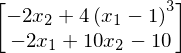

In [13]:
x1, x2 = sympy.symbols("x_1, x_2")
f_sym = (x1-1)**4 + 5 * (x2-1)**2 - 2*x1*x2
fprime_sym = [f_sym.diff(x_) for x_ in (x1, x2)]
# 梯度
sympy.Matrix(fprime_sym)

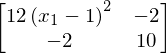

In [14]:
fhess_sym = [[f_sym.diff(x1_, x2_) for x1_ in (x1, x2)] for x2_ in (x1, x2)]
# Hessian
sympy.Matrix(fhess_sym)

使用符号表达式

In [16]:
f_lmbda = sympy.lambdify((x1, x2), f_sym, 'numpy')
fprime_lmbda = sympy.lambdify((x1, x2), fprime_sym, 'numpy')
fhess_lmbda = sympy.lambdify((x1, x2), fhess_sym, 'numpy')
# 矢量化
def func_XY_to_X_Y(f):
    """
    Wrapper for f(X) -> f(X[0], X[1])
    """
    return lambda X: np.array(f(X[0], X[1]))

f = func_XY_to_X_Y(f_lmbda)
fprime = func_XY_to_X_Y(fprime_lmbda)
fhess = func_XY_to_X_Y(fhess_lmbda)

# 优化
x_opt = optimize.fmin_ncg(f, (0, 0), fprime=fprime, fhess=fhess)
x_opt

Optimization terminated successfully.
         Current function value: -3.867223
         Iterations: 8
         Function evaluations: 10
         Gradient evaluations: 17
         Hessian evaluations: 8


array([ 1.88292613,  1.37658523])

可视化

/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


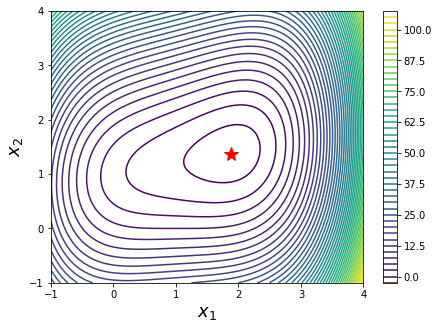

In [25]:
fig, ax = plt.subplots(figsize=(7, 5))
x_ = y_ = np.linspace(-1, 4, 100)
X, Y = np.meshgrid(x_, y_)
c = ax.contour(X, Y, f_lmbda(X, Y), 50)
ax.plot(x_opt[0], x_opt[1], 'r*', markersize=15)
ax.set_xlabel(r"$x_1$", fontsize=18)
ax.set_ylabel(r"$x_2$", fontsize=18)
plt.colorbar(c, ax=ax)
plt.show()

使用 `fmin_bfgs` 方法或者 `fmin_cg` 方法

In [26]:
x_opt = optimize.fmin_bfgs(f, (0, 0), fprime=fprime)
x_opt

Optimization terminated successfully.
         Current function value: -3.867223
         Iterations: 9
         Function evaluations: 13
         Gradient evaluations: 13


array([ 1.88292645,  1.37658596])

In [27]:
x_opt = optimize.fmin_cg(f, (0, 0), fprime=fprime)
x_opt

Optimization terminated successfully.
         Current function value: -3.867223
         Iterations: 8
         Function evaluations: 18
         Gradient evaluations: 18


array([ 1.88292612,  1.37658523])

In [28]:
# 不提供导数
x_opt = optimize.fmin_bfgs(f, (0, 0))
x_opt

Optimization terminated successfully.
         Current function value: -3.867223
         Iterations: 9
         Function evaluations: 52
         Gradient evaluations: 13


array([ 1.88292644,  1.37658595])

## 多局部最小点

多局部最小点可以使用 `brute` 放法求解，如 $4\sin x\pi + 6\sin y\pi + (x-1)^2 + (y-1)^2$ 具有多个局部极值

In [29]:
def f(X):
    x, y = X
    return (4 * np.sin(np.pi * x) + 6 * np.sin(np.pi * y)) + (x - 1)**2 + (y - 1)**2

x_start = optimize.brute(f, (slice(-3, 5, 0.5), slice(-3, 5, 0.5)), finish=None)
x_start, f(x_start)

(array([ 1.5,  1.5]), -9.5)

In [30]:
x_opt = optimize.fmin_bfgs(f, x_start)
x_opt, f(x_opt)

Optimization terminated successfully.
         Current function value: -9.520229
         Iterations: 4
         Function evaluations: 28
         Gradient evaluations: 7


(array([ 1.47586906,  1.48365787]), -9.5202292730550155)

可视化上述目标函数

/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


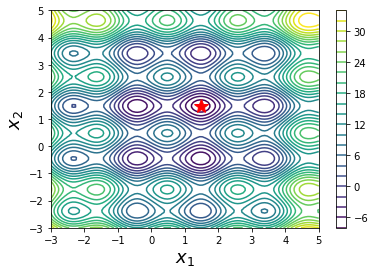

In [31]:
def func_X_Y_to_XY(f, X, Y):
    """
    Wrapper for f(X, Y) -> f([X, Y])
    """
    s = np.shape(X)
    return f(np.vstack([X.ravel(), Y.ravel()])).reshape(*s)

fig, ax = plt.subplots(figsize=(6, 4))
x_ = y_ = np.linspace(-3, 5, 100)
X, Y = np.meshgrid(x_, y_)
c = ax.contour(X, Y, func_X_Y_to_XY(f, X, Y), 25)
ax.plot(x_opt[0], x_opt[1], 'r*', markersize=15)
ax.set_xlabel(r"$x_1$", fontsize=18)
ax.set_ylabel(r"$x_2$", fontsize=18)
plt.colorbar(c, ax=ax)
plt.show()

# 非线性最小平法问题

可以使用 `leastsq` ，此方法使用的是 `Levenberg-Marquardt` 方法。

In [32]:
beta = (0.25, 0.75, 0.5)
# 定义一个方程
def f(x, b0, b1, b2):
    return b0 + b1 * np.exp(-b2 * x**2)

# 生成模拟数据
xdata = np.linspace(0, 5, 50)
y = f(xdata, *beta)
ydata = y + 0.05 * np.random.randn(len(xdata))

# 定义残差函数
def g(beta):
    return ydata - f(xdata, *beta)

# 定义初始猜想值，并求解
beta_start = (1, 1, 1)
beta_opt, beta_cov = optimize.leastsq(g, beta_start)
beta_opt

array([ 0.25955903,  0.79207113,  0.53380491])

进行可视化

/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


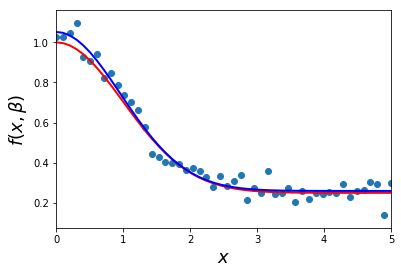

In [33]:
fig, ax = plt.subplots()
ax.scatter(xdata, ydata)
ax.plot(xdata, y, 'r', lw=2)
ax.plot(xdata, f(xdata, *beta_opt), 'b', lw=2)
ax.set_xlim(0, 5)
ax.set_xlabel(r"$x$", fontsize=18)
ax.set_ylabel(r"$f(x, \beta)$", fontsize=18)

plt.show()

也可以使用 scipy 提供的不显示定义残差函数的方法 `optimize.curve_fit`。

In [34]:
beta_opt, beta_cov = optimize.curve_fit(f, xdata, ydata)
beta_opt

array([ 0.25955903,  0.79207113,  0.53380491])

# 约束优化

约束求解可以使用 `optimize.fmin_l_bfgs_b` 来求解，通过图形化可以看出有约束和没有约束解的区别。

如:
$$
\large{
\begin{split}
f (x) = (x_1 - 1)^2 -(x_2 - 1)^2
\end{split}
}
$$
在 $2 \le x_1 \le 3, 0 \le x_2 \le 2$ 约束条件下的求解。

/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


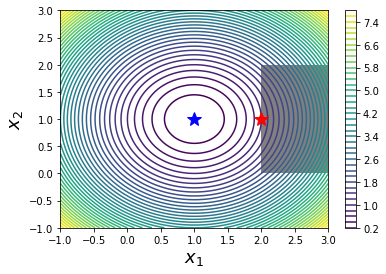

In [35]:
# 目标函数的定义
def f(X):
    x, y = X
    return (x - 1)**2 + (y - 1)**2

# 去约束求解
x_opt = optimize.minimize(f, (1, 1), method='BFGS').x

# 有约束求解
bnd_x1, bnd_x2 = (2, 3), (0, 2)
x_cons_opt = optimize.minimize(f, np.array([1, 1]), method='L-BFGS-B', 
                               bounds=[bnd_x1, bnd_x2]).x

# 绘图: 阴影部分为约束解所在区域，红色五角星为约束解
# 蓝色五角星为无约束解
fig, ax = plt.subplots(figsize=(6, 4))
x_ = y_ = np.linspace(-1, 3, 100)
X, Y = np.meshgrid(x_, y_)
c = ax.contour(X, Y, func_X_Y_to_XY(f, X, Y), 50)
ax.plot(x_opt[0], x_opt[1], 'b*', markersize=15)
ax.plot(x_cons_opt[0], x_cons_opt[1], 'r*', markersize=15)
bound_rect = plt.Rectangle((bnd_x1[0], bnd_x2[0]),
                           bnd_x1[1] - bnd_x1[0], bnd_x2[1] - bnd_x2[0],
                           facecolor="grey")
ax.add_patch(bound_rect)
ax.set_xlabel(r"$x_1$", fontsize=18)
ax.set_ylabel(r"$x_2$", fontsize=18)
plt.colorbar(c, ax=ax)
plt.show()

## 拉格朗日法

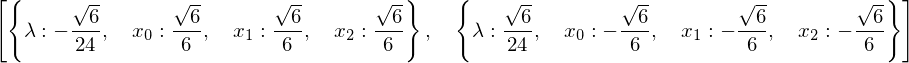

In [36]:
# 定义相关变量与函数
x = x0, x1, x2, l = sympy.symbols("x_0, x_1, x_2, lambda")
f = x0 * x1 * x2 # 目标
g = 2 * (x0 * x1 + x1 * x2 + x2 * x0) - 1 # 约束
L = f + l * g # 拉格朗日乘子法
grad_L = [sympy.diff(L, x_) for x_ in x]
sols = sympy.solve(grad_L)
sols

等式约束与不等式约束求解

如下等式约束条件为 $2 x_{0} x_{1} + 2 x_{0} x_{2} + 2 x_{1} x_{2} - 1=0$

In [37]:
# 目标
def f(X):
    return -X[0] * X[1] * X[2]

# 约束
def g(X):
    return 2 * (X[0]*X[1] + X[1] * X[2] + X[2] * X[0]) - 1

# 等式约束
constraint = dict(type='eq', fun=g)
result = optimize.minimize( f, [0.5, 1, 1.5], method='SLSQP',
                           constraints=[constraint])
result

     fun: -0.06804136862287297
     jac: array([-0.16666925, -0.16666542, -0.16666526])
 message: 'Optimization terminated successfully.'
    nfev: 95
     nit: 18
    njev: 18
  status: 0
 success: True
       x: array([ 0.40824188,  0.40825127,  0.40825165])

如下不等式约束 $x_1 - 1.75 - (x_0  - 0.75)^4 \ge 0$

/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


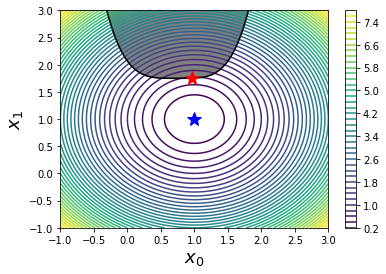

In [40]:
def f(X):
    return (X[0] - 1)**2 + (X[1] - 1)**2
def g(X):
    return X[1] - 1.75 - (X[0] - 0.75)**4
constraints = [dict(type='ineq', fun=g)]
# 有约束与无约束
x_opt = optimize.minimize(f, (0, 0), method='BFGS').x
x_cons_opt = optimize.minimize( f, (0, 0), method='SLSQP',
                               constraints=constraints).x

# 绘图
fig, ax = plt.subplots(figsize=(6, 4))
x_ = y_ = np.linspace(-1, 3, 100)
X, Y = np.meshgrid(x_, y_)
c = ax.contour(X, Y, func_X_Y_to_XY(f, X, Y), 50)
ax.plot(x_opt[0], x_opt[1], 'b*', markersize=15)
ax.plot(x_, 1.75 + (x_-0.75)**4, 'k-', markersize=15)
ax.fill_between(x_, 1.75 + (x_-0.75)**4, 3, color='grey')
ax.plot(x_cons_opt[0], x_cons_opt[1], 'r*', markersize=15)

ax.set_ylim(-1, 3)
ax.set_xlabel(r"$x_0$", fontsize=18)
ax.set_ylabel(r"$x_1$", fontsize=18)
plt.colorbar(c, ax=ax)
plt.show()

## 线性方程组约束

即有多个线性方程组成的约束，可以写成$\min_x c^Tx$，其中$Ax \le b, x \ge 0$，其中最小化方程为 $f(x)=-x_0 + 2x_1 - 3x_2$，三个不等式约束为：
$$
\large{
\begin{split}
x_0 + x_1 \le 1 \\
-x_0 +3 x_1 \le 2\\
-x_1 + x_2 \le 3
\end{split}
}
$$

那么 $c = (-1, 2, -3), b = (1, 2, 3)$ 其中 A 为：
$$
\large{
A=
\begin{pmatrix}
1 & 1 & 0 \\
-1 & 3 & 0 \\
0 & -1 & 1 
\end{pmatrix}
}
$$

In [41]:
c = np.array([-1.0, 2.0, -3.0])
A = np.array([[ 1.0, 1.0, 0.0],
              [-1.0, 3.0, 0.0],
              [ 0.0, -1.0, 1.0]])
b = np.array([1.0, 2.0, 3.0])
A_ = cvxopt.matrix(A)
b_ = cvxopt.matrix(b)
c_ = cvxopt.matrix(c)
sol = cvxopt.solvers.lp(c_, A_, b_)
sol

Optimal solution found.


{'dual infeasibility': 2.967195843610875e-17,
 'dual objective': -10.0,
 'dual slack': 2.7755575615628914e-17,
 'gap': 0.0,
 'iterations': 0,
 'primal infeasibility': 0.0,
 'primal objective': -10.0,
 'primal slack': -0.0,
 'relative gap': 0.0,
 'residual as dual infeasibility certificate': None,
 'residual as primal infeasibility certificate': None,
 's': <3x1 matrix, tc='d'>,
 'status': 'optimal',
 'x': <3x1 matrix, tc='d'>,
 'y': <0x1 matrix, tc='d'>,
 'z': <3x1 matrix, tc='d'>}